In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer


import pickle

In [2]:
data = pd.read_csv('./spam_ham_dataset.csv')
data = data.iloc[:, 1:]
data.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
print('Dataset include {} emails'.format(data.shape[0]))
print('Ham email: {}'.format(data['label_num'].value_counts()[0]))
print('Spam email: {}'.format(data['label_num'].value_counts()[1]))

Dataset include 5171 emails
Ham email: 3672
Spam email: 1499


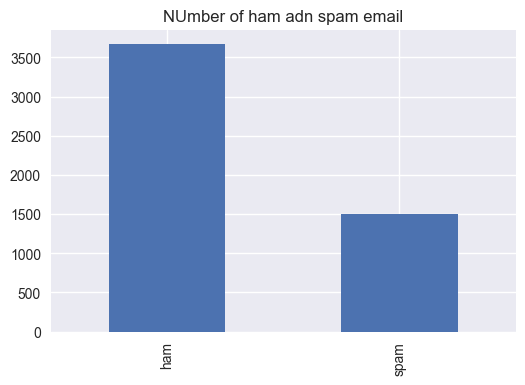

In [4]:
plt.style.use('seaborn')
plt.figure(figsize=(6, 4), dpi=100)
plt.title('NUmber of ham adn spam email')
data['label'].value_counts().plot(kind='bar')

In [5]:
# text and label_num
new_data = data.iloc[:, 1:]
length = len(new_data)
new_data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
new_data['text'] = new_data['text'].str.lower()
new_data.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291\r\n...,0
1,"subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: re : indian springs\r\nthis deal is t...,0


In [7]:
stop_words = set(stopwords.words('english'))
stop_words.add('subject')

In [8]:
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z]+')
    lemmatizer = WordNetLemmatizer()
    token = tokenizer.tokenize(text)
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

In [9]:
new_data['text'] = new_data['text'].apply(text_process)
new_data.head()

,text,label_num
0,"[enron, methanol, meter, follow, note, gave, m...",0
1,"[hpl, nom, january, see, attached, file, hplno...",0
2,"[neon, retreat, ho, ho, ho, around, wonderful,...",0
3,"[photoshop, window, office, cheap, main, trend...",1
4,"[indian, spring, deal, book, teco, pvr, revenu...",0


In [10]:
seed = 20190524
X = new_data['text']
y = new_data['label_num']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)  # 75% train set and 25% test set

train = pd.concat([X_train, y_train], axis=1)  # train set
test = pd.concat([X_test, y_test], axis=1)  # test set

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [12]:
print('Train set has {} emails，Test set has {} emails'.format(train.shape[0], test.shape[0]))

Train set has 3878 emails，Test set has 1293 emails


0    2769
1    1109
Name: label_num, dtype: int64


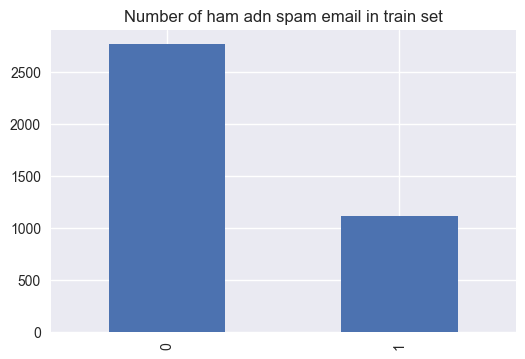

In [13]:
print(train['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
plt.title('Number of ham adn spam email in train set')
train['label_num'].value_counts().plot(kind='bar')

0    903
1    390
Name: label_num, dtype: int64


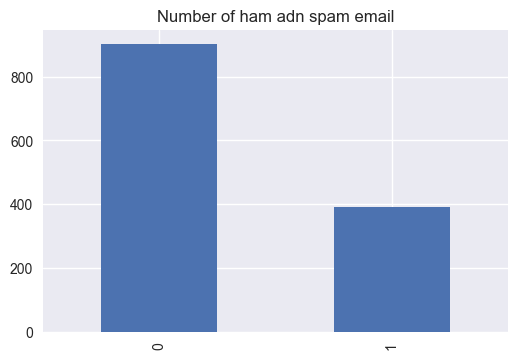

In [14]:
print(test['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
plt.title('Number of ham adn spam email')
test['label_num'].value_counts().plot(kind='bar')

In [15]:
print('0 is ham email and 1 is spam email in test set')
ham_train = train[train['label_num'] == 0]  # ham email
spam_train = train[train['label_num'] == 1]  # spam email

0 is ham email and 1 is spam email in test set


In [16]:
ham_train_part = ham_train['text'].sample(10, random_state=seed)  # select 10 ham email in random
spam_train_part = spam_train['text'].sample(10, random_state=seed)  # select 10 spam email in random

In [17]:
part_words = []  # part of word
for text in pd.concat([ham_train_part, spam_train_part]):
    part_words += text

In [18]:
part_words_set = set(part_words)
print('Word table has {} words'.format(len(part_words_set)))

Word table has 1528 words


In [19]:
train_part_texts = [' '.join(text) for text in np.concatenate((spam_train_part.values, ham_train_part.values))]
# word into sentence in train set
train_all_texts = [' '.join(text) for text in train['text']]
# word into sentence in test set
test_all_texts = [' '.join(text) for text in test['text']]

In [20]:
cv = CountVectorizer()
part_fit = cv.fit(train_part_texts)
train_all_count = cv.transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

In [21]:
print('train set', train_tfidf_matrix.shape)
print('test set', test_tfidf_matrix.shape)

train set (3878, 1513)
test set (1293, 1513)


In [22]:
#Naive Bayesian model
mnb = MultinomialNB()
mnb.fit(train_tfidf_matrix, y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
y_pred_prob = mnb.predict_proba(test_tfidf_matrix)
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

In [24]:
y_pred = mnb.predict(test_tfidf_matrix)
print('Naive Bayesian_classification_report:')
print(classification_report(y_test, y_pred))
mnb_acc = accuracy_score(y_test, y_pred)
print('Naive bayesian accuracy:' , mnb_acc)

Naive Bayesian_classification_report:
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       903
          1       0.90      0.86      0.88       390

avg / total       0.93      0.93      0.93      1293

Naive bayesian accuracy: 0.9265274555297757


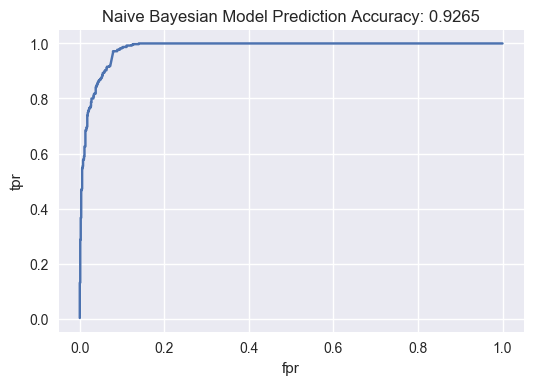

In [25]:
# diagram
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr1, tpr1)
plt.title('Naive Bayesian Model Prediction Accuracy: {:.4f}'.format(mnb_acc))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [26]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf.fit(train_tfidf_matrix, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
y_RF_pred_prob = clf.predict_proba(test_tfidf_matrix)
fpr2, tpr2, thresholds = roc_curve(y_test, y_RF_pred_prob[:, 1])

In [28]:
y_RF_pred = clf.predict(test_tfidf_matrix)
print('RF_classification_report:')
print(classification_report(y_test,y_RF_pred))
rf_acc = accuracy_score(y_test, y_RF_pred)
print('Random Forest accuracy:' , rf_acc)

RF_classification_report:
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       903
          1       0.92      0.92      0.92       390

avg / total       0.95      0.95      0.95      1293

Random Forest accuracy: 0.9528228924980665


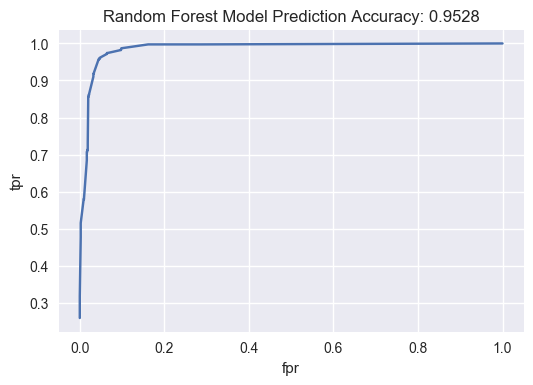

In [29]:
# diagram
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr2, tpr2)
plt.title('Random Forest Model Prediction Accuracy: {:.4f}'.format(rf_acc))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [30]:
#Decision Tree
from sklearn import tree
dt = tree.DecisionTreeClassifier().fit(train_tfidf_matrix, y_train)

In [31]:
y_tree_pred_prob = dt.predict_proba(test_tfidf_matrix)
fpr3, tpr3, thresholds = roc_curve(y_test, y_tree_pred_prob[:, 1])

In [32]:
y_tree_pred = dt.predict(test_tfidf_matrix)
print('tree_classification_report:')
print(classification_report(y_test, y_tree_pred))
dt_acc = accuracy_score(y_test, y_tree_pred)
print('Decision tree accuracy:' , dt_acc)

tree_classification_report:
             precision    recall  f1-score   support

          0       0.97      0.95      0.96       903
          1       0.88      0.93      0.90       390

avg / total       0.94      0.94      0.94      1293

Decision tree accuracy: 0.9396751740139211


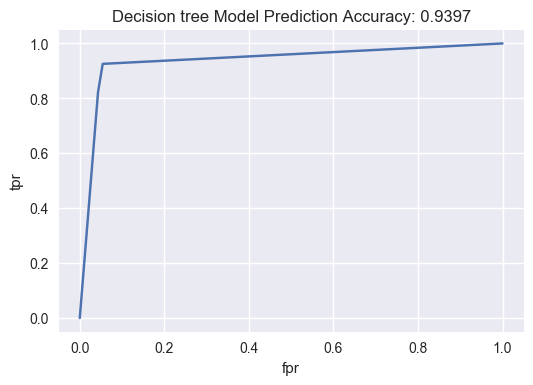

In [33]:
# diagram
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr3, tpr3)
plt.title('Decision tree Model Prediction Accuracy: {:.4f}'.format(dt_acc))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [34]:
pickle.dump(clf,open('tfidf_random_forest.sav','wb'))
pickle.dump(mnb,open('tfidf_naive_baysian_model.sav','wb'))
pickle.dump(dt,open('tfidf_decision_tree_model.sav','wb'))

In [35]:
clf.predict(test_tfidf_matrix)

array([0, 0, 0, ..., 1, 0, 1])

In [36]:
mnb.predict(test_tfidf_matrix)

array([0, 0, 1, ..., 0, 0, 1])

In [37]:
########## Implementing ansemble learning #######
########## Implementing ansemble learning #######
########## Implementing ansemble learning #######
ensembleCounter = 0;
result_vect = []
for i in range(test_tfidf_matrix.shape[0]):
    if (y_tree_pred[i] == 1):
        ensembleCounter+=1
    if (y_pred[i] == 1):
        ensembleCounter+=1
    if (y_RF_pred[i] == 1):
        ensembleCounter+=1
    if(ensembleCounter>=2):
        result_vect.append(1)
    else:
        result_vect.append(0)
    ensembleCounter = 0;

In [59]:
print(classification_report(y_test,result_vect))

             precision    recall  f1-score   support

          0       0.98      0.96      0.97       903
          1       0.92      0.96      0.94       390

avg / total       0.96      0.96      0.96      1293



In [43]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.util import ngrams

In [44]:
# vect = CountVectorizer(ngram_range=(6,6))
# X_Train = vect.fit_transform(train_all_texts)
# X_Test = vect.fit_transform(test_all_texts)
# #X_Train = tfidf.fit_transform(X_Train)
# #X_Test = tfidf.fit_transform(X_Test)

In [79]:
# ngramDT = tree.DecisionTreeClassifier().fit(X_Train, y_train)

In [45]:
# ngramDTpred = ngramDT.predict(X_Test)
# np.shape(X_Test)